In [1]:
import os
from datetime import datetime
#from datetime import date
import pymysql
from sqlalchemy import create_engine
from decouple import config 
from dotenv import load_dotenv
import pandas as pd
import numpy as np
from enum import Enum


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
load_dotenv()
# get the environment variables needed
USER = config('USRCaris')
PASSWORD = config('PASSCaris')
HOSTNAME = config('HOSTCaris')
DBNAME = config('DBCaris')

# get the engine to connect and fetch
engine = create_engine(
    f"mysql+pymysql://{USER}:{PASSWORD}@{HOSTNAME}/{DBNAME}")
query = '''
SELECT 
    p.patient_code,
    b.first_name,
    b.last_name,
    b.dob,
    dsd.a1_dat_entvyou_a_ft_jjmmaa_egz_010817 AS interview_date,
    dgs.date AS session_date,
    dg.name AS group_name,
    dh.name AS hub_name,
    lc.name AS hub_commune,
    ld.name AS hub_departement,
    dsd.f_komin AS interview_commune,
    ldt.name AS topic,
    au.email as created_by,
    au.username,
    dgs.created_at as date_session_were_entered
FROM
    caris_db.dream_group_attendance dga
        LEFT JOIN
    dream_member dm ON dm.id_patient = dga.id_patient
        LEFT JOIN
    dreams_surveys_data dsd ON dsd.case_id = dm.case_id
        LEFT JOIN
    dream_group_session dgs ON dgs.id = dga.id_group_session
        LEFT JOIN
    dream_group dg ON dg.id = dgs.id_group
        LEFT JOIN
    dream_hub dh ON dh.id = dg.id_dream_hub
        LEFT JOIN
    lookup_commune lc ON lc.id = dh.commune
        LEFT JOIN
    lookup_departement ld ON ld.id = lc.departement
        LEFT JOIN
    lookup_dreams_topic ldt ON ldt.id = dgs.topic
        LEFT JOIN
    patient p ON p.id = dga.id_patient
        LEFT JOIN
    beneficiary b ON b.id_patient = dga.id_patient
        left join 
            auth_users au  on au.id=dgs.created_by
WHERE
    dga.value = 'P'
'''

evaluation_performance_attendance = pd.read_sql_query(
    query, engine, parse_dates=True)


# close the pool of connection
engine.dispose()


True

In [3]:
## get the test excel file from Query (au besoin de verification)
evaluation_performance_attendance.to_excel('epa.xlsx',index=False,na_rep="NULL")

## Duplication aspect

In [4]:
evaluation_performance_attendance.dtypes

patient_code                         object
first_name                           object
last_name                            object
dob                                  object
interview_date                       object
session_date                         object
group_name                           object
hub_name                             object
hub_commune                          object
hub_departement                      object
interview_commune                    object
topic                                object
created_by                           object
username                             object
date_session_were_entered    datetime64[ns]
dtype: object

In [5]:
epa_deduplicate = evaluation_performance_attendance.drop_duplicates(subset=['patient_code'])

In [6]:
evaluation_performance_attendance.shape
epa_deduplicate.shape

(566529, 15)

(30110, 15)

## Period of control aspect

In [7]:
class Constante(Enum):
    march_1_2021 = '2021-03-01'
    specific = "2021-10-05"
    workbook = "rapport_agents_saisie_des_sessions_04Octobre2021.xlsx"

In [8]:
presencesaisie_startmars_endnow = evaluation_performance_attendance[evaluation_performance_attendance["date_session_were_entered"]>=Constante.march_1_2021.value]
presencesaisie_specific = evaluation_performance_attendance[evaluation_performance_attendance["date_session_were_entered"]>=Constante.specific.value] 
epa_startmars_endnow= epa_deduplicate[epa_deduplicate['date_session_were_entered']>=Constante.march_1_2021.value]

In [9]:
presencesaisie_startmars_endnow.shape
presencesaisie_specific.shape
epa_startmars_endnow.shape

(244972, 15)

(9139, 15)

(11964, 15)

## Count by agents in descending order

In [10]:
performance_session_global  = epa_startmars_endnow.groupby(['created_by']).count()
presence_global = presencesaisie_startmars_endnow.groupby(['created_by']).count()
presence_specific = presencesaisie_specific.groupby(['created_by']).count()

In [11]:
performance_session_global.sort_values(ascending=False, by='patient_code',inplace=True)
presence_global.sort_values(ascending=False, by='patient_code',inplace=True)
presence_specific.sort_values(ascending=False, by='patient_code',inplace=True)


In [12]:
performance_session  = pd.DataFrame( {"nombre_de_filles": performance_session_global['patient_code'], f"nombre_de_presence_saisie_depuis_le_{Constante.march_1_2021.value}":presence_global["patient_code"],
                                      f"nombre_de_presence_saisie_au_{Constante.specific.value}":presence_specific["patient_code"]})
performance_session.fillna(0,inplace=True)
performance_session

,nombre_de_filles,nombre_de_presence_saisie_depuis_le_2021-03-01,nombre_de_presence_saisie_au_2021-10-05
created_by,,,
billyjolicoeur95@gmail.com,3566,62235,471.0
blonnichel@yahoo.fr,1331,20282,0.0
byronfabrice9@gmail.com,1728,29091,208.0
coldina2020@gmail.com,30,1848,0.0
diegoarmando.dorlean@carisfoundationintl.org,305,27537,2103.0
elionafredly7@gmail.com,1543,32646,1877.0
ernst.belabre@carisfoundationintl.org,1093,20367,1604.0
francenelstjean.saed@yahoo.com,629,10095,0.0
gerald.poteau@carisfoundationintl.org,401,10928,1071.0


## MODIFY BELOW TO GET THE DIFFERENCE GIVEN LAST WEEK

In [13]:
week_before_perf = pd.read_excel(Constante.workbook.value, sheet_name="filles_saisies_global", index_col="created_by")
performance_session["nombre_de_filles_saisie_par_rapport_a_periode_precedente"] =  performance_session["nombre_de_filles"] - week_before_perf["nombre_de_filles"]
performance_session.fillna(0.0,inplace=True)
performance_session.nombre_de_filles_saisie_par_rapport_a_la_semaine_derniere = performance_session.nombre_de_filles_saisie_par_rapport_a_periode_precedente.astype("int16")
performance_session[f"nombre_de_presence_saisie_au_{Constante.specific.value}"] = performance_session[f"nombre_de_presence_saisie_au_{Constante.specific.value}"].astype('int16')

<ipython-input-13-6a1af7d83748>:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  performance_session.nombre_de_filles_saisie_par_rapport_a_la_semaine_derniere = performance_session.nombre_de_filles_saisie_par_rapport_a_periode_precedente.astype("int16")


In [14]:
columns_performance_session = performance_session.columns.sort_values().tolist()
performance_session = performance_session.reindex(columns=columns_performance_session)

In [15]:
performance_session.drop(columns=["nombre_de_presence_saisie_depuis_le_2021-03-01"], inplace=True)

In [16]:
performance_session

,nombre_de_filles,nombre_de_filles_saisie_par_rapport_a_periode_precedente,nombre_de_presence_saisie_au_2021-10-05
created_by,,,
billyjolicoeur95@gmail.com,3566,28,471
blonnichel@yahoo.fr,1331,0,0
byronfabrice9@gmail.com,1728,0,208
coldina2020@gmail.com,30,0,0
diegoarmando.dorlean@carisfoundationintl.org,305,4,2103
elionafredly7@gmail.com,1543,105,1877
ernst.belabre@carisfoundationintl.org,1093,54,1604
francenelstjean.saed@yahoo.com,629,0,0
gerald.poteau@carisfoundationintl.org,401,12,1071


## Agent per Commune

In [17]:
performance_agents_par_commune = epa_startmars_endnow.pivot_table(index='created_by',columns='hub_commune',values='patient_code',aggfunc='count',fill_value=0,margins=True, margins_name="Grand Total")
#performance_agents_par_commune.reset_index(inplace=True)

In [18]:
performance_agents_par_commune.sort_values(by=("Grand Total") ,ascending=False,inplace=True)

In [19]:
performance_agents_par_commune

hub_commune,Cap-Haïtien,Carrefour,Delmas,Desdunes,Dessalines,Grande Saline,Gressier,Kenscoff,La Chapelle,Liancourt,...,Montrouis,Petite Rivière de l'Artibonite,Plaine-du-Nord,Port-au-Prince,Pétionville,Quartier-Morin,Saint-Marc,Tabarre,Verrettes,Grand Total
created_by,,,,,,,,,,,,,,,,,,,,,
Grand Total,865,1079,449,185,683,415,668,1644,478,161,...,166,518,356,759,335,264,1012,243,864,11964
billyjolicoeur95@gmail.com,563,173,220,18,0,0,73,957,20,23,...,0,175,265,73,109,185,35,125,10,3566
byronfabrice9@gmail.com,73,260,28,0,58,69,182,329,39,0,...,0,114,70,199,125,25,41,42,0,1728
elionafredly7@gmail.com,136,291,40,0,0,35,273,68,0,0,...,0,32,0,382,22,14,28,42,62,1543
blonnichel@yahoo.fr,0,0,0,0,0,0,0,0,80,83,...,82,0,0,0,0,0,656,0,430,1331
ernst.belabre@carisfoundationintl.org,38,260,0,58,0,56,96,0,136,28,...,2,28,2,0,0,35,135,0,186,1093
twoody103@gmail.com,30,95,134,0,6,137,44,150,0,0,...,0,36,6,60,57,0,0,20,0,799
francenelstjean.saed@yahoo.com,0,0,0,2,619,4,0,0,0,0,...,0,4,0,0,0,0,0,0,0,629
gerald.poteau@carisfoundationintl.org,0,0,0,37,0,55,0,2,79,0,...,21,27,3,45,0,0,62,4,66,401


## Reporting Performance de mars 2021 a date

In [20]:
pac = pd.ExcelWriter('rapport_agents_saisie_des_sessions.xlsx',engine='xlsxwriter')
performance_session.to_excel(pac,sheet_name='filles_saisies_global')
performance_agents_par_commune.to_excel(pac,sheet_name="filles_saisies_par_communes")
pac.save()

## Verification sheet

In [21]:
def fiscalYear21(date):
    if date.year == 2021 and date.month>=1 and date.month<=3:
        return "FY21Q2"
    elif date.year == 2020 and date.month>=10 and date.month<=12:
        return "FY21Q1"
    elif date.year == 2021 and date.month>=4 and date.month<=6:
        return "FY21Q3"
    elif date.year == 2021 and date.month>=7 and date.month<=9:
        return "FY21Q4"
    else:
        return "Q3fy20-Q4fy20"
    
def validTimeOnSystem(date):
    if date>= datetime.strptime("2020-04-01","%Y-%m-%d") and date<= datetime.now():
        return "required_Time_on"
    else:
        return "not_valid_time_on"

In [22]:
epa_startmars_endnow.interview_date.isna().sum()

0

In [23]:
%%capture
epa_startmars_endnow["date_entevyou"] = pd.to_datetime( epa_startmars_endnow.interview_date)

In [24]:
epa_startmars_endnow.date_entevyou

321557   2020-11-20
321575   2020-11-20
321588   2020-10-07
321589   2020-10-05
321590   2020-10-07
            ...    
566116   2020-06-28
566117   2018-07-16
566118   2020-06-09
566119   2018-06-25
566120   2020-07-22
Name: date_entevyou, Length: 11964, dtype: datetime64[ns]

In [25]:
%%capture
epa_startmars_endnow["fiscal_year"] = epa_startmars_endnow.date_entevyou.map(fiscalYear21)
epa_startmars_endnow["time_On_System"] = epa_startmars_endnow.date_entevyou.map(validTimeOnSystem)

In [26]:
epa_startmars_endnow.columns

Index(['patient_code', 'first_name', 'last_name', 'dob', 'interview_date',
       'session_date', 'group_name', 'hub_name', 'hub_commune',
       'hub_departement', 'interview_commune', 'topic', 'created_by',
       'username', 'date_session_were_entered', 'date_entevyou', 'fiscal_year',
       'time_On_System'],
      dtype='object')

In [27]:
epa_startmars_endnow.dob

321557    2009-03-28
321575    2007-08-16
321588    2003-02-01
321589    2004-12-24
321590    2004-10-13
             ...    
566116    2007-07-07
566117    2001-07-16
566118    2000-11-24
566119    2000-09-07
566120    2004-02-23
Name: dob, Length: 11964, dtype: object

In [28]:
from dateutil.relativedelta import relativedelta

In [29]:
def get_age(date):
    return relativedelta(datetime.today(),date).years

def tranche_age_classique(age):
        if age>=10 and age<=14:
            return "10-14"
        elif age>=15 and age<=19:
            return "15-19"
        elif age>=20 and age<=24:
            return "20-24"
        elif age>=25 and age<=29:
            return "25-29"
        else:
            return "not_valid_age"
        
def tranche_age_mineur_majeur(age):
        if age>=10 and age<=17:
            return "10-17"
        elif age>=18 and age<=19:
            return "18-19"
        elif age>=20 and age<=24:
            return "20-24"
        elif age>=25 and age<=29:
            return "25-29"
        else:
            return "not_valid_age"

In [30]:
%%capture
epa_startmars_endnow["age"] = epa_startmars_endnow.dob.map(get_age)
epa_startmars_endnow["age_range"] = epa_startmars_endnow.age.map(tranche_age_classique)
epa_startmars_endnow["newage_range"] = epa_startmars_endnow.age.map(tranche_age_mineur_majeur)

In [31]:
epa_startmars_endnow.age.unique()
epa_startmars_endnow.age_range.unique()
epa_startmars_endnow.newage_range.unique()

array([ 12,  14,  18,  16,  15,  17,  19,  13,  11,  10,  20,  24,  22,
        23,  21,  25,   2,   9,   3,   7,  26, 121,   6,   4,   1],
      dtype=int64)

array(['10-14', '15-19', '20-24', '25-29', 'not_valid_age'], dtype=object)

array(['10-17', '18-19', '20-24', '25-29', 'not_valid_age'], dtype=object)

In [32]:
epa_startmars_endnow.columns

Index(['patient_code', 'first_name', 'last_name', 'dob', 'interview_date',
       'session_date', 'group_name', 'hub_name', 'hub_commune',
       'hub_departement', 'interview_commune', 'topic', 'created_by',
       'username', 'date_session_were_entered', 'date_entevyou', 'fiscal_year',
       'time_On_System', 'age', 'age_range', 'newage_range'],
      dtype='object')

In [33]:
epa_fy21 = epa_startmars_endnow[(epa_startmars_endnow.age_range !="not_valid_age") & (epa_startmars_endnow.age_range != "25-29") & (epa_startmars_endnow.fiscal_year != "Q3fy20-Q4fy20")]
all_epa = epa_startmars_endnow[(epa_startmars_endnow.age_range !="not_valid_age") & (epa_startmars_endnow.age_range != "25-29")]

valid_epa_fy21 = epa_startmars_endnow[(epa_startmars_endnow.time_On_System == "required_Time_on")&(epa_startmars_endnow.age_range !="not_valid_age") & (epa_startmars_endnow.age_range != "25-29") & (epa_startmars_endnow.fiscal_year != "Q3fy20-Q4fy20")]
valid_all_epa = epa_startmars_endnow[(epa_startmars_endnow.time_On_System == "required_Time_on")&(epa_startmars_endnow.age_range !="not_valid_age") & (epa_startmars_endnow.age_range != "25-29")]

In [34]:
print("epa_startmars")
epa_startmars_endnow.patient_code.count()
print("epa_fy21")
epa_fy21.patient_code.count()
print("all_epa")
all_epa.patient_code.count()
print("valid epa_fy21")
valid_epa_fy21.patient_code.count()
print("valid_all_epa")
valid_all_epa.patient_code.count()
print("not valid")
epa_startmars_endnow.patient_code.count() - valid_all_epa.patient_code.count()



epa_startmars


11964

epa_fy21


7730

all_epa


11827

valid epa_fy21


7730

valid_all_epa


9411

not valid


2553

<Figure size 1152x576 with 0 Axes>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'AGYW, entered since march 2021 by the data clerk, presence in currilum')

Text(2102.0, 0.0, '2100')

Text(1883.0, 1.0, '1881')

Text(1893.0, 2.0, '1891')

Text(1860.0, 3.0, '1858')

Text(-80, -20, 'source: HIVHaiti')

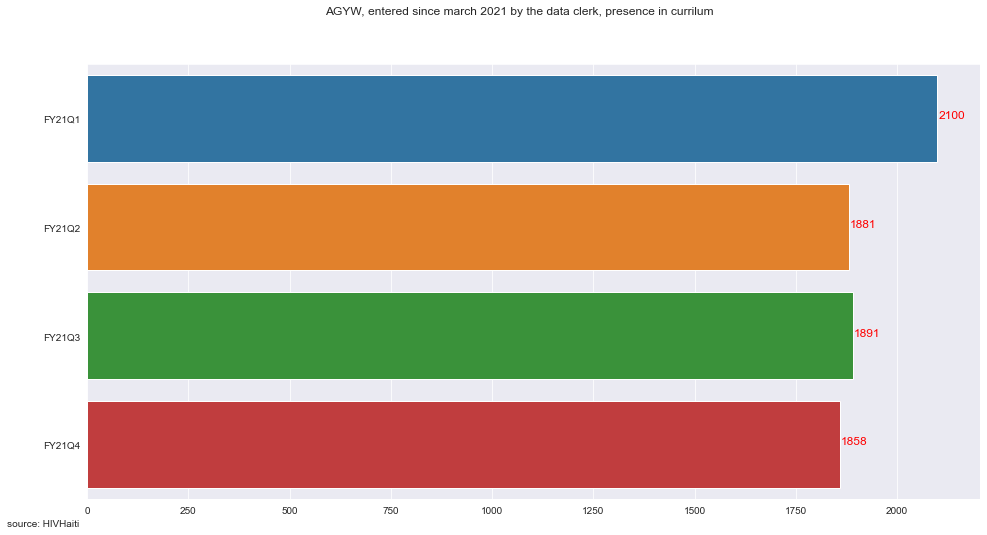

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pivot_epa = epa_fy21.pivot_table(columns="fiscal_year",values="patient_code",fill_value=0,aggfunc='count')

X= list(pivot_epa.columns)
Y= pivot_epa.values.tolist()[0]
data = []
colonnes = []

for x,y in zip(X,Y):
    data.append(y)
    colonnes.append(x)


df = pd.DataFrame({"fy":colonnes, "dt":data})

plt.figure(figsize=(16,8))
sns.set_style("darkgrid")
splot = sns.barplot(x="dt",y="fy",data=df)
splot.set_xlabel("")
splot.set_ylabel("")
plt.suptitle("AGYW, entered since march 2021 by the data clerk, presence in currilum")
for p in splot.patches:
    width = p.get_width()
    plt.text(2+p.get_width(), p.get_y()+0.50*p.get_height(),
             '{:1.0f}'.format(width), fontdict=dict(color="red",fontsize=12))
    
plt.annotate(
    "source: HIVHaiti",(0,0), (-80,-20), fontsize=10, 
             xycoords='axes fraction', textcoords='offset points', va='top'
)

plt.savefig("curriculum_Presence",dpi=400)

<Figure size 1152x576 with 0 Axes>

Text(0.5, 0, '')

Text(0, 0.5, '')

Text(0.5, 0.98, 'AGYW, entered since march 2021 by the data clerk, presence in currilum')

Text(2102.0, 0.0, '2100')

Text(1883.0, 1.0, '1881')

Text(1893.0, 2.0, '1891')

Text(1860.0, 3.0, '1858')

Text(1683.0, 4.0, '1681')

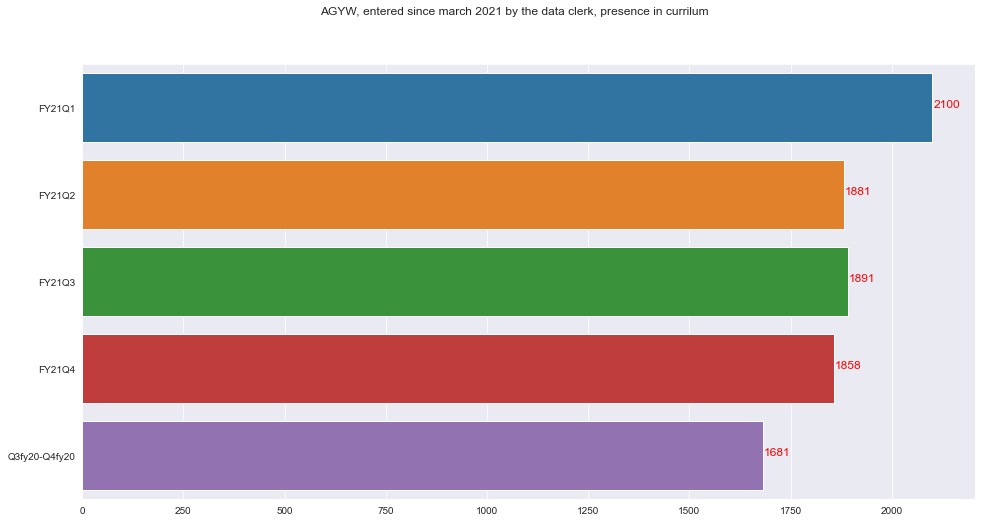

In [36]:
pivot_all_epa = valid_all_epa.pivot_table(columns="fiscal_year",values="patient_code",fill_value=0,aggfunc='count')

X= list(pivot_all_epa.columns)
Y= pivot_all_epa.values.tolist()[0]
data = []
colonnes = []

for x,y in zip(X,Y):
    data.append(y)
    colonnes.append(x)


df = pd.DataFrame({"fy":colonnes, "dt":data})

plt.figure(figsize=(16,8))
sns.set_style("darkgrid")
splot = sns.barplot(x="dt",y="fy",data=df)
splot.set_xlabel("")
splot.set_ylabel("")
plt.suptitle("AGYW, entered since march 2021 by the data clerk, presence in currilum")
for p in splot.patches:
    width = p.get_width()
    plt.text(2+p.get_width(), p.get_y()+0.50*p.get_height(),
             '{:1.0f}'.format(width),fontdict=dict(color="red",fontsize=12))

plt.savefig("curriculum_all_fiscal",dpi=1000)